#### Importing libraries

In [96]:
import pandas as pd
import json
from itertools import islice

#### Importing datasets

In [97]:
df = pd.read_csv("districts.csv")

#### dropping irrelevent columns

In [98]:
df.drop(columns=['Recovered','Other','Tested','Deceased'], inplace = True)

In [99]:
f = open("neighbor-districts-modified.json")
filtered_district = json.load(f)

In [100]:
f1 = open("state_code_mapping.json")
state_code_mapping = json.load(f1)

#### 
1. converting cummulative values to delta values
2. findig intersection of covid database and neighbors district database

In [101]:
for key, values in df.groupby(['State', 'District']):
    if key[1]!="Unknown":
        district_name = state_code_mapping[key[0]]+"_"+key[1]
    else:
        district_name = state_code_mapping[key[0]] + "_" + key[1]
    
    if district_name not in filtered_district:
        df.drop(values.index, inplace=True)
    else:
        first_value = df.at[values.index[0],'Confirmed']
        df.loc[values.index, 'Confirmed'] = df.loc[values.index, 'Confirmed'].diff()
        df.at[values.index[0],'Confirmed'] = first_value
        df.loc[values.index, 'District'] = district_name

In [102]:
df['Confirmed'] = df['Confirmed'].mask(df['Confirmed']<0).ffill().fillna(0).convert_dtypes()

In [103]:
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [104]:
df.drop(df[df['Date']>'2021-08-14'].index, inplace=True)

In [105]:
all_districts = df['District'].unique()

#### Taking dataset from 15-04-2020 to 14-08-201

In [106]:
date_range = pd.date_range('2020-04-16','2020-04-25')
for district in all_districts:
    a = pd.DataFrame({'Date': date_range, 'District':district, 'Confirmed': 0,'State':df[df['District']==district]['State'].unique()[0]})
    df = pd.concat([a,df])

In [107]:
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [108]:
df.sort_values(['Date','District'],ignore_index=True, inplace=True)
df

,Date,District,Confirmed,State
0,2020-04-16,AP_Anantapur,0,Andhra Pradesh
1,2020-04-16,AP_Chittoor,0,Andhra Pradesh
2,2020-04-16,AP_East Godavari,0,Andhra Pradesh
3,2020-04-16,AP_Guntur,0,Andhra Pradesh
4,2020-04-16,AP_Krishna,0,Andhra Pradesh
...,...,...,...,...
294541,2021-08-14,WB_Purba Bardhaman,11,West Bengal
294542,2021-08-14,WB_Purba Medinipur,47,West Bengal
294543,2021-08-14,WB_Purulia,3,West Bengal
294544,2021-08-14,WB_South 24 Parganas,60,West Bengal


In [109]:
df['Week']=0
df

,Date,District,Confirmed,State,Week
0,2020-04-16,AP_Anantapur,0,Andhra Pradesh,0
1,2020-04-16,AP_Chittoor,0,Andhra Pradesh,0
2,2020-04-16,AP_East Godavari,0,Andhra Pradesh,0
3,2020-04-16,AP_Guntur,0,Andhra Pradesh,0
4,2020-04-16,AP_Krishna,0,Andhra Pradesh,0
...,...,...,...,...,...
294541,2021-08-14,WB_Purba Bardhaman,11,West Bengal,0
294542,2021-08-14,WB_Purba Medinipur,47,West Bengal,0
294543,2021-08-14,WB_Purulia,3,West Bengal,0
294544,2021-08-14,WB_South 24 Parganas,60,West Bengal,0


#### finding no of cases per week starting from sunday

In [110]:
x=-1
def myfunc(Series):
    global x
    x+=2
    if(x==141):
        x=1
    return x
    
df1 = df.set_index('Date').groupby('District').resample('w-sat').agg({'Confirmed':'sum','Week':myfunc})

#### finding no of cases per week starting from thursday

In [111]:
y=0
def myfunc2(Series):
    global y
    y+=2
    if(y==142):
        y=2
    return y
    
df2 = df.set_index('Date').groupby('District').resample('w-wed').agg({'Confirmed':'sum','Week':myfunc2})

In [112]:
df1.reset_index(inplace=True)
df2.reset_index(inplace = True)
df_week = pd.concat([df1,df2])

In [113]:
df_week.sort_values(['District','Date','Week'],inplace=True)
df_week

,District,Date,Confirmed,Week
0,AP_Anantapur,2020-04-18,0,1
0,AP_Anantapur,2020-04-22,0,2
1,AP_Anantapur,2020-04-25,0,3
1,AP_Anantapur,2020-04-29,58,4
2,AP_Anantapur,2020-05-02,71,5
...,...,...,...,...
43117,WB_Uttar Dinajpur,2021-08-04,65,136
43118,WB_Uttar Dinajpur,2021-08-07,66,137
43118,WB_Uttar Dinajpur,2021-08-11,59,138
43119,WB_Uttar Dinajpur,2021-08-14,56,139


#### finding monthtly cases of each district

In [114]:
month_days = [30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31]
df_month = pd.DataFrame(columns=['District','Month','Cases'])
for key, value in df.groupby('District'):
    month_count = 1
    indexes = iter(value.index)
    splitted_index = [list(islice(indexes, elem)) for elem in month_days]
    for i in splitted_index:
        s = df.loc[i, 'Confirmed'].sum()
        df_month = df_month.append({'District': key, 'Month': month_count, 'Cases':s}, ignore_index=True)
        month_count+=1
df_month

,District,Month,Cases
0,AP_Anantapur,1,122
1,AP_Anantapur,2,363
2,AP_Anantapur,3,3328
3,AP_Anantapur,4,25134
4,AP_Anantapur,5,21141
...,...,...,...
10467,WB_Uttar Dinajpur,13,7405
10468,WB_Uttar Dinajpur,14,1978
10469,WB_Uttar Dinajpur,15,337
10470,WB_Uttar Dinajpur,16,143


#### Dividing dataset into two parts (one contain year 2020 data and another contain year 2021 data)

In [115]:
df1  = df_week[df_week['Week']<=70]
df2  = df_week[df_week['Week']>70]

#### finding weeks in year 2020 dataset where each district has maximum cases

In [116]:
df1_max = pd.DataFrame(columns={'District','Week','Max_Cases'})
for key, value in df1.groupby(['District']):
    max_cases = value['Confirmed'].max()
    week = value[value['Confirmed']==max_cases]['Week'].values[0]
    df1_max = df1_max.append({'District':key,'Week':week,'Max_Cases':max_cases},ignore_index=True)
df1_max

,District,Max_Cases,Week
0,AP_Anantapur,7703,32
1,AP_Chittoor,6869,41
2,AP_East Godavari,9979,44
3,AP_Guntur,6213,31
4,AP_Krishna,2883,50
...,...,...,...
611,WB_Purba Bardhaman,778,56
612,WB_Purba Medinipur,1333,43
613,WB_Purulia,635,45
614,WB_South 24 Parganas,1853,58


#### Plotting a scalar plot to know in which weeks we get most of maximum cases from most of the districts

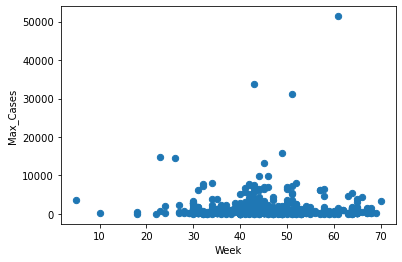

In [117]:
df1_max.plot.scatter(x = 'Week', y = 'Max_Cases', s = 40);

##### On observing plot we found out that week 30 to 55 have most of the maximum cases from most of the districts therefore our wave 1 is from week 30 to week 55

#### finding weeks in year 2021 dataset where each district has maximum cases

In [118]:
df2_max = pd.DataFrame(columns={'Week','Max_Cases'})
for key, value in df2.groupby(['District']):
    max_cases = value['Confirmed'].max()
    week = value[value['Confirmed']==max_cases]['Week'].values[0]
    df2_max = df2_max.append({'Week':week,'Max_Cases':max_cases},ignore_index=True)
df2_max

,Max_Cases,Week
0,17856,114
1,18635,115
2,22783,115
3,13053,113
4,7085,115
...,...,...
611,4883,112
612,6072,113
613,3155,108
614,8640,115


#### Plotting a scalar plot to know in which weeks we get most of maximum cases from most of the districts

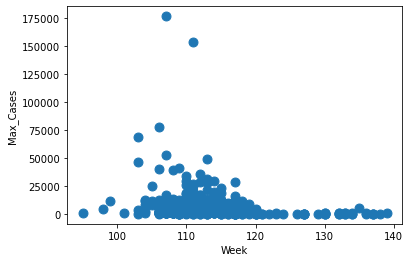

In [119]:
df2_max.plot.scatter(x = 'Week', y = 'Max_Cases', s = 80);

#### we have wave 2 from week 100 to week 120

#### taking dataset of wave 1

In [120]:
df_wave1_week = df1[(df1['Week']>=30) | (df1['Week']<=55)]
df_wave1_week

,District,Date,Confirmed,Week
0,AP_Anantapur,2020-04-18,0,1
0,AP_Anantapur,2020-04-22,0,2
1,AP_Anantapur,2020-04-25,0,3
1,AP_Anantapur,2020-04-29,58,4
2,AP_Anantapur,2020-05-02,71,5
...,...,...,...,...
43082,WB_Uttar Dinajpur,2020-12-02,256,66
43083,WB_Uttar Dinajpur,2020-12-05,311,67
43083,WB_Uttar Dinajpur,2020-12-09,225,68
43084,WB_Uttar Dinajpur,2020-12-12,143,69


#### taking dataset of wave 2

In [121]:
df_wave2 = df2[(df2['Week']>=100) | (df2['Week']<=120)]
df_wave2

,District,Date,Confirmed,Week
35,AP_Anantapur,2020-12-19,132,71
35,AP_Anantapur,2020-12-23,133,72
36,AP_Anantapur,2020-12-26,127,73
36,AP_Anantapur,2020-12-30,127,74
37,AP_Anantapur,2021-01-02,126,75
...,...,...,...,...
43117,WB_Uttar Dinajpur,2021-08-04,65,136
43118,WB_Uttar Dinajpur,2021-08-07,66,137
43118,WB_Uttar Dinajpur,2021-08-11,59,138
43119,WB_Uttar Dinajpur,2021-08-14,56,139


#### finding week in which a district has maximum cases in wave1

In [123]:
df_wave1_max = pd.DataFrame(columns={'District','Week'})
for key, value in df_wave1_week.groupby(['District']):
    max_cases = value['Confirmed'].max()
    week = value[value['Confirmed']==max_cases]['Week'].values[0]
    df_wave1_max = df_wave1_max.append({'District':key,'Week':week},ignore_index=True)
df_wave1_max

,District,Week
0,AP_Anantapur,32
1,AP_Chittoor,41
2,AP_East Godavari,44
3,AP_Guntur,31
4,AP_Krishna,50
...,...,...
611,WB_Purba Bardhaman,56
612,WB_Purba Medinipur,43
613,WB_Purulia,45
614,WB_South 24 Parganas,58


#### finding week in which a district has maximum cases in wave1

In [124]:
df_wave2_max = pd.DataFrame(columns={'District','Week'})
for key, value in df_wave2.groupby(['District']):
    max_cases = value['Confirmed'].max()
    week = value[value['Confirmed']==max_cases]['Week'].values[0]
    df_wave2_max = df_wave2_max.append({'District':key,'Week':week},ignore_index=True)
df_wave2_max

,District,Week
0,AP_Anantapur,114
1,AP_Chittoor,115
2,AP_East Godavari,115
3,AP_Guntur,113
4,AP_Krishna,115
...,...,...
611,WB_Purba Bardhaman,112
612,WB_Purba Medinipur,113
613,WB_Purulia,108
614,WB_South 24 Parganas,115


In [125]:
df_week_result = pd.DataFrame()
df_week_result.insert(0, 'district_id', df_wave1_max['District'])
df_week_result.insert(1, 'wave1-weekid', df_wave1_max['Week'])
df_week_result.insert(2, 'wave2-weekid', df_wave2_max['Week'])
df_week_result

,district_id,wave1-weekid,wave2-weekid
0,AP_Anantapur,32,114
1,AP_Chittoor,41,115
2,AP_East Godavari,44,115
3,AP_Guntur,31,113
4,AP_Krishna,50,115
...,...,...,...
611,WB_Purba Bardhaman,56,112
612,WB_Purba Medinipur,43,113
613,WB_Purulia,45,108
614,WB_South 24 Parganas,58,115


In [126]:
df_wave1_month = df_month[(df_month['Month']>=4) & (df_month['Month']<=7)]
df_wave1_month

,District,Month,Cases
3,AP_Anantapur,4,25134
4,AP_Anantapur,5,21141
5,AP_Anantapur,6,11754
6,AP_Anantapur,7,4331
20,AP_Chittoor,4,19147
...,...,...,...
10444,WB_South 24 Parganas,7,7703
10458,WB_Uttar Dinajpur,4,1102
10459,WB_Uttar Dinajpur,5,1366
10460,WB_Uttar Dinajpur,6,1134


In [127]:
df_wave2_month = df_month[(df_month['Month']>=13) & (df_month['Month']<=15)]
df_wave2_month

,District,Month,Cases
12,AP_Anantapur,13,40446
13,AP_Anantapur,14,39358
14,AP_Anantapur,15,5136
29,AP_Chittoor,13,57044
30,AP_Chittoor,14,55756
...,...,...,...
10451,WB_South 24 Parganas,14,24186
10452,WB_South 24 Parganas,15,2817
10467,WB_Uttar Dinajpur,13,7405
10468,WB_Uttar Dinajpur,14,1978


In [128]:
df_wave1_month_max = pd.DataFrame(columns={'District','Month'})
for key, value in df_wave1_month.groupby(['District']):
    max_cases = value['Cases'].max()
    month = value[value['Cases']==max_cases]['Month'].values[0]
    df_wave1_month_max = df_wave1_month_max.append({'District':key,'Month':month},ignore_index=True)
df_wave1_month_max

,District,Month
0,AP_Anantapur,4
1,AP_Chittoor,5
2,AP_East Godavari,5
3,AP_Guntur,4
4,AP_Krishna,6
...,...,...
611,WB_Purba Bardhaman,7
612,WB_Purba Medinipur,5
613,WB_Purulia,5
614,WB_South 24 Parganas,7


In [129]:
df_wave2_month_max = pd.DataFrame(columns={'District','Month'})
for key, value in df_wave2_month.groupby(['District']):
    max_cases = value['Cases'].max()
    month = value[value['Cases']==max_cases]['Month'].values[0]
    df_wave2_month_max = df_wave2_month_max.append({'District':key,'Month':month},ignore_index=True)
df_wave2_month_max

,District,Month
0,AP_Anantapur,13
1,AP_Chittoor,13
2,AP_East Godavari,14
3,AP_Guntur,13
4,AP_Krishna,13
...,...,...
611,WB_Purba Bardhaman,13
612,WB_Purba Medinipur,14
613,WB_Purulia,13
614,WB_South 24 Parganas,13


### merging all result of week

In [131]:
df_week_result.insert(3, 'wave1-monthid', df_wave1_month_max['Month'])
df_week_result.insert(4, 'wave2-monthid', df_wave2_month_max['Month'])
df_week_result

,district_id,wave1-weekid,wave2-weekid,wave1-monthid,wave2-monthid
0,AP_Anantapur,32,114,4,13
1,AP_Chittoor,41,115,5,13
2,AP_East Godavari,44,115,5,14
3,AP_Guntur,31,113,4,13
4,AP_Krishna,50,115,6,13
...,...,...,...,...,...
611,WB_Purba Bardhaman,56,112,7,13
612,WB_Purba Medinipur,43,113,5,14
613,WB_Purulia,45,108,5,13
614,WB_South 24 Parganas,58,115,7,13


In [ ]:
creating csv file for result

In [133]:
df_week_result.to_csv("district-peaks.csv")